<a href="https://colab.research.google.com/github/KushagraIndurkhya/bilateral-filtering/blob/main/bilateral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update
!apt-get install -y libopencv-dev

In [ ]:
!find .. -name 'libopencv*'

In [ ]:
!pkg-config --cflags --libs opencv4

In [94]:
!mkdir -p output
!mkdir -p input
# !curl https://drive.google.com/file/d/11A87h7OyeiavThxcRz6OeExEi7u---TC/view?usp=share_link
!wget wget "https://drive.google.com/uc?export=download&id=11A87h7OyeiavThxcRz6OeExEi7u---TC" -O input/original.png


--2023-02-09 08:27:44--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2023-02-09 08:27:44--  https://drive.google.com/uc?export=download&id=11A87h7OyeiavThxcRz6OeExEi7u---TC
Resolving drive.google.com (drive.google.com)... 108.177.119.139, 108.177.119.138, 108.177.119.113, ...
Connecting to drive.google.com (drive.google.com)|108.177.119.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1ehsmgfmas9ekrpsmlfntkj7dgjn328t/1675931250000/07584919166158982710/*/11A87h7OyeiavThxcRz6OeExEi7u---TC?e=download&uuid=6446e97e-40ee-405f-884a-77af883889ad [following]
--2023-02-09 08:27:45--  https://doc-0g-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1ehsmgfmas9ekrpsmlfntkj7dgjn328t/1675931250000/07584919166158982710/*/11A87h7OyeiavThxcRz6OeExEi7u---TC?e=download&uuid=6

In [95]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import log10, sqrt

  
def PSNR(im1, im2):
    im1=cv2.imread(im1)
    im2=cv2.imread(im2)
    mse = np.mean((im1-im2) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

   
diameter=3
sigma_for_gaussian=50


img=cv2.imread("input/original.png",0)
gauss_noise=np.zeros(img.shape,dtype=np.uint8)
cv2.randn(gauss_noise,128,10)
gauss_noise=(gauss_noise*0.8).astype(np.uint8)
gn_img=cv2.add(img,gauss_noise)
cv2.imwrite("input/input.png", gn_img)

img=cv2.imread("input/input.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gaussian_blur = cv2.GaussianBlur(gray, (diameter, diameter), sigma_for_gaussian)
cv2.imwrite("output/gaussian_blurred_image.png", gaussian_blur)

mean_filter=cv2.blur(img, (diameter, diameter))
cv2.imwrite("output/mean_filtered_image.png", mean_filter)

median_filter=cv2.medianBlur(img, diameter)
cv2.imwrite("output/median_filtered_image.png", median_filter)



True

In [96]:
%%writefile bilateral.cpp

#include <iostream>
#include <stdio.h>
#include <opencv2/opencv.hpp>
#include <thread>
#include <chrono>

using namespace cv;
using namespace std;

float distance(int x, int y, int i, int j) {
    return float(sqrt(pow(x - i, 2) + pow(y - j, 2)));
}

double gaussian(float x, double sigma) {
    return exp(-(pow(x, 2))/(2 * pow(sigma, 2))) / (2 * CV_PI * pow(sigma, 2));

}

void applyBilateralFilter(Mat source, Mat filteredImage, int x, int y, int diameter, double sigmaI, double sigmaS) {
    double iFiltered = 0;
    double wP = 0;
    int neighbor_x = 0;
    int neighbor_y = 0;
    int half = diameter / 2;

    for(int i = 0; i < diameter; i++) {
        for(int j = 0; j < diameter; j++) {
            neighbor_x = x - (half - i);
            neighbor_y = y - (half - j);
            double gi = gaussian(source.at<uchar>(neighbor_x, neighbor_y) - source.at<uchar>(x, y), sigmaI);
            double gs = gaussian(distance(x, y, neighbor_x, neighbor_y), sigmaS);
            double w = gi * gs;
            iFiltered = iFiltered + source.at<uchar>(neighbor_x, neighbor_y) * w;
            wP = wP + w;
        }
    }
    iFiltered = iFiltered / wP;
    filteredImage.at<double>(x, y) = iFiltered;


}

Mat addPadding(Mat source, int radius) {
    int row = source.rows;
    int col = source.cols;
    int paddedRow = row + 2 * radius;
    int paddedCol = col + 2 * radius;
    Mat paddedImage = Mat::zeros(paddedRow, paddedCol, source.type());
    for(int i = 0; i < row; i++) {
        for(int j = 0; j < col; j++) {
            paddedImage.at<uchar>(i + radius, j + radius) = source.at<uchar>(i, j);
        }
    }
    return paddedImage;
}


Mat removePadding(Mat source, int radius) {
    int height = source.rows - 2 * radius;
    int width = source.cols - 2 * radius;

    Mat dest = Mat::zeros(height, width,CV_64F); 

    for (int i = radius; i < source.rows - radius; i++) {
        for (int j = radius; j < source.cols - radius; j++) {
            dest.at<uchar>(i - radius, j - radius) = source.at<uchar>(i, j);
        }
    }

    return dest;
}


Mat bilateralFilterSeq(Mat source, int diameter, double sigmaI, double sigmaS) {
    Mat filteredImage = Mat::zeros(source.rows,source.cols,CV_64F);

    //int radius= diameter / 2;
    //source=addPadding(source,radius);
    int radius=0;

    int width = source.cols;
    int height = source.rows;

    for(int i = radius; i < height - radius; i++) {
        for(int j = radius; j < width - radius; j++) {
            applyBilateralFilter(source, filteredImage, i, j, diameter, sigmaI, sigmaS);
        }
    }
    //filteredImage=removePadding(filteredImage,radius);
    return filteredImage;
}

Mat bilateralFilterParallel(Mat source, int diameter, double sigmaI, double sigmaS,int numThreads) {
    Mat filteredImage = Mat::zeros(source.rows, source.cols, CV_64F);
    int radius = 0;

    int width = source.cols;
    int height = source.rows;

    //int numThreads = thread::hardware_concurrency();
    
    vector<thread> threads;

    int rowsPerThread = height / numThreads;

    int start = radius;
    int end = start + rowsPerThread;

    for (int t = 0; t < numThreads; t++) {
        if (t == numThreads - 1) {
            end = height - radius;
        }

        threads.push_back(thread([&, start, end]() {
            for (int i = start; i < end; i++) {
                for (int j = radius; j < width - radius; j++) {
                    applyBilateralFilter(source, filteredImage, i, j, diameter, sigmaI, sigmaS);
                }
            }
        }));

        start = end;
        end = start + rowsPerThread;
    }

    for (auto &t : threads) {
        t.join();
    }

    return filteredImage;
}


int main(int argc, char** argv ) {
    Mat src;
    src = imread( argv[1], 0 );
    int diameter= atoi(argv[2]);
    int sigma_space= atoi(argv[3]);
    int sigma_intensity= atoi(argv[4]);
    int numThreads = 10;
    

    if ( !src.data )
    {
        printf("No image data \n");
        return -1;
    }

    auto start = chrono::high_resolution_clock::now();
    Mat filteredImageSeq = bilateralFilterSeq(src, diameter, sigma_intensity,sigma_space);
    auto end = chrono::high_resolution_clock::now();
    auto durationSeq = chrono::duration_cast<chrono::milliseconds>(end - start).count();


    start = chrono::high_resolution_clock::now();
    Mat filteredImageOpenCV;
    bilateralFilter(src, filteredImageOpenCV, diameter,sigma_intensity,sigma_space);
    end = chrono::high_resolution_clock::now();
    auto durationOpenCV = chrono::duration_cast<chrono::milliseconds>(end - start).count();

    start = chrono::high_resolution_clock::now();
    Mat filteredImageParallel = bilateralFilterParallel(src, diameter, sigma_intensity,sigma_space,numThreads);
    end = chrono::high_resolution_clock::now();
    auto durationParallel = chrono::duration_cast<chrono::milliseconds>(end - start).count();

    cout<<"Sequential: "<<durationSeq<<"ms \n";
    cout<<"Parallel: "<<durationParallel<<"ms"<<" using "<<numThreads<<" threads\n";

    imwrite("output/original_image_grayscale.png", src);
    imwrite("output/filtered_image_OpenCV.png", filteredImageOpenCV);
    imwrite("output/filtered_image_Seq.png", filteredImageSeq);
    imwrite("output/filtered_image_Parallel.png", filteredImageParallel);

    return 0;
}

Writing bilateral.cpp


In [97]:
!g++ -std=c++11 -pthread -I/usr/include/opencv4/opencv -I/usr/include/opencv4 bilateral.cpp -o bilateral -lopencv_stitching -lopencv_aruco -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_highgui -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_line_descriptor -lopencv_quality -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_datasets -lopencv_text -lopencv_dnn -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core


In [98]:
!./bilateral input/input.png 15 16 16

Sequential: 19123ms 
Parallel: 13246ms using 10 threads


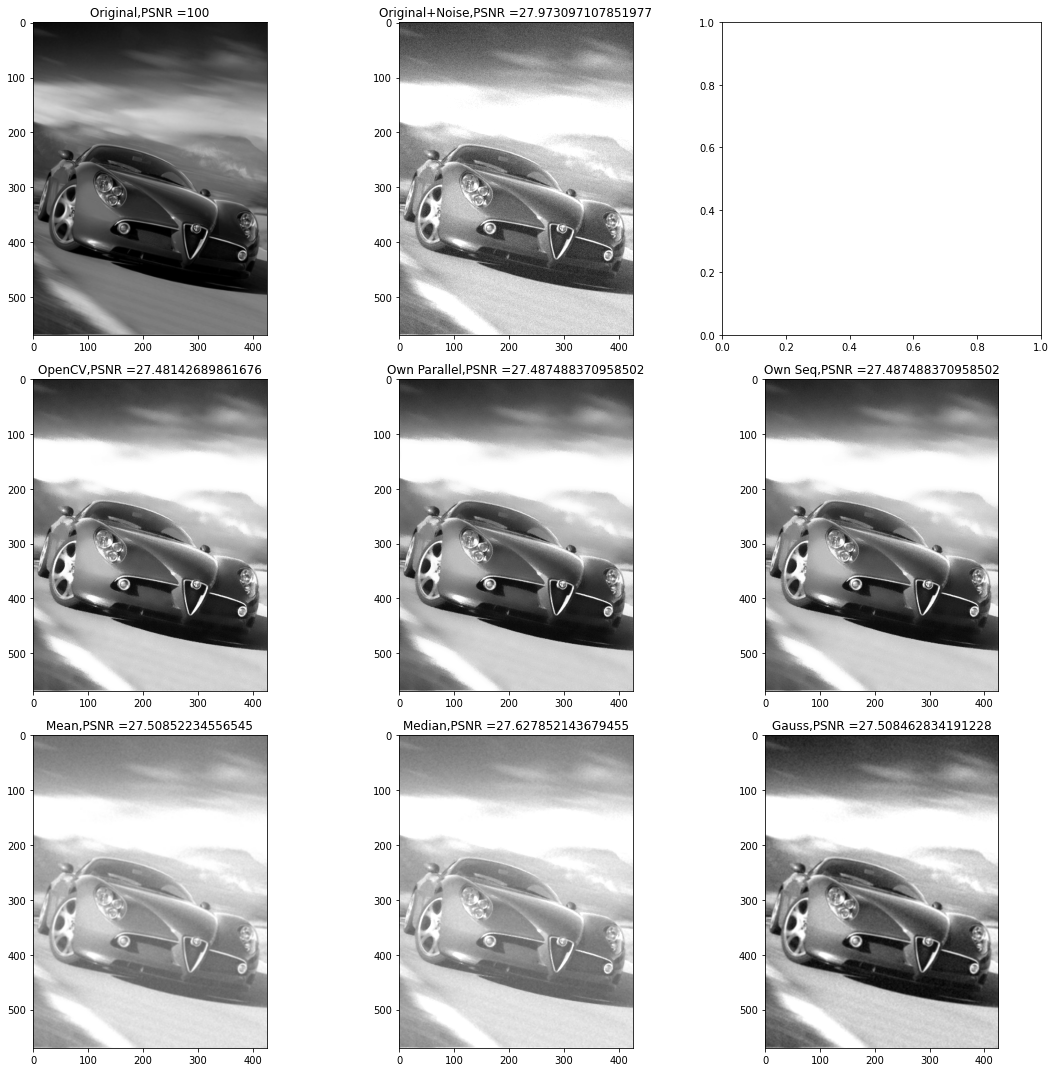

In [99]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# base_image_location="output/original_image_grayscale.png"
base_image_location="input/original.png"

img0,im0psnr = mpimg.imread("input/original.png"),PSNR(base_image_location,"input/original.png")
img1,im1psnr = mpimg.imread("output/original_image_grayscale.png"),PSNR(base_image_location,"output/original_image_grayscale.png")
img2,im2psnr = mpimg.imread("output/filtered_image_Parallel.png"),PSNR(base_image_location,"output/filtered_image_Parallel.png")
img3,im3psnr = mpimg.imread("output/filtered_image_Seq.png"),PSNR(base_image_location,"output/filtered_image_Seq.png")
img4,im4psnr = mpimg.imread("output/mean_filtered_image.png"),PSNR(base_image_location,"output/mean_filtered_image.png")
img5,im5psnr = mpimg.imread("output/median_filtered_image.png"),PSNR(base_image_location,"output/median_filtered_image.png")
img6,im6psnr= mpimg.imread("output/gaussian_blurred_image.png"),PSNR(base_image_location,"output/gaussian_blurred_image.png")
img7,im7psnr = mpimg.imread("output/filtered_image_OpenCV.png"),PSNR(base_image_location,"output/filtered_image_OpenCV.png")


fig, axs = plt.subplots(3, 3, figsize=(15,15))
axs[0,0].imshow(img0, cmap='gray')
axs[0,0].set_title("Original,PSNR ="+str(im0psnr))

axs[0,1].imshow(img1, cmap='gray')
axs[0,1].set_title("Original+Noise,PSNR ="+str(im1psnr))

axs[1,0].imshow(img7, cmap='gray')
axs[1,0].set_title("OpenCV,PSNR ="+str(im7psnr))

axs[1,1].imshow(img2, cmap='gray')
axs[1,1].set_title("Own Parallel,PSNR ="+str(im2psnr))

axs[1,2].imshow(img3, cmap='gray')
axs[1,2].set_title("Own Seq,PSNR ="+str(im3psnr))

axs[2,0].imshow(img4, cmap='gray')
axs[2,0].set_title("Mean,PSNR ="+str(im4psnr))

axs[2,1].imshow(img5, cmap='gray')
axs[2,1].set_title("Median,PSNR ="+str(im5psnr))

axs[2,2].imshow(img6, cmap='gray')
axs[2,2].set_title("Gauss,PSNR ="+str(im6psnr))


plt.tight_layout()
plt.show()

In [93]:
!rm -r input output
!rm bilateral bilateral.cpp